In [1]:
import os
import h5py
import pytest
import numpy as np
import glob
import shutil
import tempfile

with open('../dask_io/config.json') as json_conffile:
    import json
    data = json.load(json_conffile)
    import sys
    sys.path.insert(0, data['dask_path'])
    sys.path.insert(0, '../')

import dask
import dask.array as da

from dask_io.optimizer.cases.case_config import Split, Merge
from dask_io.optimizer.cases.case_creation import get_arr_chunks
from dask_io.optimizer.configure import enable_clustering, disable_clustering
from dask_io.optimizer.utils.utils import ONE_GIG, CHUNK_SHAPES_EXP1
from dask_io.optimizer.utils.get_arrays import get_dask_array_from_hdf5
from dask_io.optimizer.utils.array_utils import inspect_h5py_file
from dask_io.optimizer.utils.get_arrays import create_random_dask_array, save_to_hdf5

buffer_size = 4 * ONE_GIG
path = './small_array_nochunk.hdf5'
shape_to_test = (20,20,20)

In [2]:
# from tests/utils
def create_test_array_nochunk(file_path, shape):
    if not os.path.isfile(file_path):
        arr = create_random_dask_array(shape, distrib='normal', dtype=np.float16)
        save_to_hdf5(arr, file_path, physik_cs=None, key='/data', compression=None)

In [3]:
def split():
    case = Split(path, shape_to_test)
    case.split_hdf5_multiple('./', nb_blocks=None)
    arr = case.get()
    arr.compute()
    case.clean()

In [4]:
old_cwd = os.getcwd()
tmpdir = tempfile.TemporaryDirectory()
os.chdir(tmpdir.name)
create_test_array_nochunk(path, (100, 100, 100))
split()
case = Merge('./reconstructed.hdf5')
case.merge_hdf5_multiple('./', store=False)
reconstructed_array = case.get()
#os.chdir(old_cwd)

Creating a new random array
- shape: (100, 100, 100)
- distrib: normal
- dtype: <class 'numpy.float16'>
Saving a dask array at ./small_array_nochunk.hdf5:
- physik_cs: None
- key: /data
- compression: None
Array successfully saved.

Inspecting created file...


In [5]:
reconstructed_array

dask.array<concatenate, shape=(100, 100, 100), dtype=float32, chunksize=(20, 20, 20)>

In [6]:
hl_graph = reconstructed_array.__dask_graph__()

In [14]:
# hl_graph.layers.keys()

In [8]:
for k, v in hl_graph.dependencies.items():
    if "concatenate" in k:
        print(k, ':')
        print(f'\t{v}')
        print("\n")

concatenate-f9fc69044b7b6ed9e977fff5aaadc530 :
	{'concatenate-17f2d30acf7823bdffdebf44813b5e46', 'concatenate-dc15f637fbb9cc7c5239a812358dbb98', 'concatenate-b32bc8c6749eacd6a8bcc369d0e49156', 'concatenate-d861da9996fbbf517b2c971905719f93', 'concatenate-eed929013fadf1f9f4c973e391721d19'}


concatenate-eed929013fadf1f9f4c973e391721d19 :
	{'concatenate-ab98f8cb9b329178071b2f1c09e882bb', 'concatenate-094248252b1426a2bc06e1dc91c2a9cf', 'concatenate-4dac1144bfdc418f6b8683e78115b16a', 'concatenate-d72425a2b8c869c8213e2b897ad313aa', 'concatenate-a1ee8736ef603fb221bab8649eb24d0c'}


concatenate-094248252b1426a2bc06e1dc91c2a9cf :
	{'array-2eb22c23ea6f16a2b37469d604b62c4b', 'array-ffda58706bf25c56e6f6b14f7ac8b05e', 'array-b501a4473ab0c7ac9d018046195dc151', 'array-a120d4dfb4fb67f20b48d7a7b522c4cc', 'array-e79d98ec4bd3f5b8fa00f3198ec2baa9'}


concatenate-ab98f8cb9b329178071b2f1c09e882bb :
	{'array-93d54f0bc72793e95c8a5f43374c10ea', 'array-31e8d7e759d178ffbf951d9d36cc50d7', 'array-eefbc82f0b5c6ff86

In [9]:
for k in reconstructed_array.dask.dicts.keys():
    print(k)

concatenate-f9fc69044b7b6ed9e977fff5aaadc530
concatenate-eed929013fadf1f9f4c973e391721d19
concatenate-094248252b1426a2bc06e1dc91c2a9cf
array-2eb22c23ea6f16a2b37469d604b62c4b
array-ffda58706bf25c56e6f6b14f7ac8b05e
array-e79d98ec4bd3f5b8fa00f3198ec2baa9
array-b501a4473ab0c7ac9d018046195dc151
array-a120d4dfb4fb67f20b48d7a7b522c4cc
concatenate-ab98f8cb9b329178071b2f1c09e882bb
array-31e8d7e759d178ffbf951d9d36cc50d7
array-93d54f0bc72793e95c8a5f43374c10ea
array-3251d83f76753846043c0d357b252764
array-ff1199af4c99fd394fd93902e9ca79f7
array-eefbc82f0b5c6ff861d902c0ac9093ce
concatenate-a1ee8736ef603fb221bab8649eb24d0c
array-3149f49afbf85f93b9b31145c54657d8
array-7e0b11e263d67d63a57d59f7b3b6a3c5
array-e90e82ec0246474fcbed58c7b8f2b2f7
array-3e38978caefc53db9615dfc09e580cf7
array-60bf00feb0e8d479e4564acc173779b2
concatenate-d72425a2b8c869c8213e2b897ad313aa
array-9769b261cc6804f6a5efe70e7b46d4ec
array-59a4ede178f0a811643ec41918905611
array-999135b8db053ff32ff5bd3581083251
array-84571fd38ec9b7248598f8

In [10]:
reconstructed_array.chunks

((20, 20, 20, 20, 20), (20, 20, 20, 20, 20), (20, 20, 20, 20, 20))

In [11]:
out_file = h5py.File('./reconstructed.hdf5', 'w')
dset = out_file.create_dataset('/data', shape=reconstructed_array.shape)
reconstructed_array = reconstructed_array.rechunk((20,100,100))
task = da.store(reconstructed_array, dset, compute=False)

In [12]:
task.dask.dicts.keys()

dict_keys([139830300376032, 139829778337456, 139829777786352, 139829777366704])

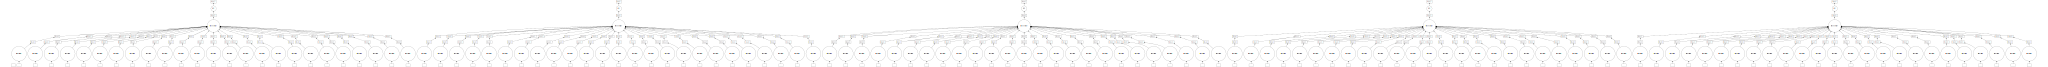

In [15]:
task.visualize('/tmp/dask_io_test.svg')